In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler

from functions.eval import *
from functions.cbi import *
from functions.utils import *
import warnings
warnings.filterwarnings("ignore")

In [2]:
nruns = 10
imputer = MissForest(criterion = ('mse', 'gini'), random_state = 0)
missing_rates = np.arange(1, 5)*0.2
test_size = 0.4

In [3]:
data = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data',
                  sep = ",")
data = data.drop(['name'], axis = 1)
X, y = data.drop(['status'], axis = 1), data['status']
print(np.array([sum(y==0), sum(y==1)]))
print(X.shape)
print(X.head())
X = X.to_numpy()
y = np.asarray(y)

[ 48 147]
(195, 22)
   MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
0      119.992       157.302        74.997         0.00784           0.00007   
1      122.400       148.650       113.819         0.00968           0.00008   
2      116.682       131.111       111.555         0.01050           0.00009   
3      116.676       137.871       111.366         0.00997           0.00009   
4      116.014       141.781       110.655         0.01284           0.00011   

   MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
0   0.00370   0.00554     0.01109       0.04374             0.426  ...   
1   0.00465   0.00696     0.01394       0.06134             0.626  ...   
2   0.00544   0.00781     0.01633       0.05233             0.482  ...   
3   0.00502   0.00698     0.01505       0.05492             0.517  ...   
4   0.00655   0.00908     0.01966       0.06425             0.584  ...   

   MDVP:APQ  Shimmer:DDA      NHR     HNR      RPDE   

In [4]:
def one_run(X, y, imputer = MissForest(), classifier = RandomForestClassifier(),
            test_size = 0.4, missing_rate = 0.8, cat_vars = None):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= test_size)
 
    # Introduce missing data to X_train
    X_train_missing = introduce_missing_data(X_train.copy(), missing_rate)
    
    X_train_cbi, y_train_cbi = cbi_train(X_train, y_train, cat_vars, imputer)
    classifier.fit(X_train_cbi, y_train)    
    accuracy_cbi = accuracy_score(y_test, classifier.predict(X_test))        
    
    
    X_train_imputed = imputer.fit_transform(X_train_missing, cat_vars = cat_vars)
    classifier.fit(X_train_imputed, y_train)    
    accuracy_imputed = accuracy_score(y_test, classifier.predict(X_test))        
    
    return accuracy_cbi, accuracy_imputed

In [5]:
res_all = []
for missing_rate in missing_rates:
    res = np.array([one_run(X, y, imputer = imputer, classifier = RandomForestClassifier(),
                test_size = test_size, missing_rate = missing_rate) for i in range(nruns)])
    res = np.array([np.mean(res, axis = 0)]).flatten().round(3)
    print("result at missing rate", missing_rate, "\n", res)
    res_all.append(res)   

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
result at missing rate 0.2 
 [0.896 0.897]
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 0
Iteration: 1
Iteration: 2
Iteratio

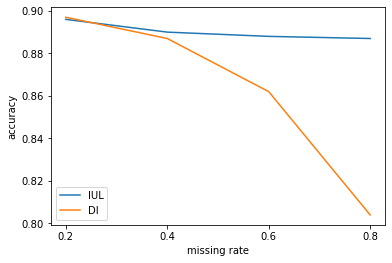

In [7]:
from matplotlib import pyplot as plt
df = pd.DataFrame(np.asarray(res_all), columns = ['IUL', 'DI'], index = missing_rates)
plot = df.plot()
plot.set_xlabel("missing rate")
plot.set_ylabel("accuracy")
plt.xticks(missing_rates)
plot.get_figure().savefig("parkinson.png")